### 머신러닝의 성능 평가 지표

    머신러닝의 예측 성능 평가 지표는 estimator에 달려있음
     1. 회귀 : 실제 값과 예측값의 오차 평균값에 기반. ex) MAE, MSE, RMSLE 등
     2. 분류 : 일반적으로는 실제 데이터와 예측 데이터의 오류를 기반으로 하지만 상황에 따라 조금 더 복잡해짐 ex) 정확도, F1 score 등

### 1. 정확도(Accuracy)

    실제 데이터와 예측데이터가 얼마나 같은지를 판단하는 지표
    
    정확도 = 예측결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
    
    가장 직관적이지만 경우에 따라서 ML 모델의 성능을 왜곡할 수 있음

#### 1.1 타이타닉 데이터 셋

In [1]:
# 아무런 학습을 하지 않고 성별에 따라서만 생존자를 예측하는 MyDummyClassifier 클래스 생성

from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
        return pred

In [2]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 칼럼 제거 함수
def drop_features(df):
    df.drop(['Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행 함수
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 모든 과정을 총괄하는 함수 생성
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
# 정의한 클래스로 타이타닉 생존자 예측 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

## 정의한 Dummy Classifier를 이용 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

my_prediction = myclf.predict(X_test)
print(f'Dummy Classifier의 정확도는 : {accuracy_score(my_prediction, y_test):.4f}')

Dummy Classifier의 정확도는 : 0.7877


#### 1.2 MNIST 데이터 셋

    단지 성별만 가지고 예측한 모델의 정확도가 80%에 육박
    특히 레이블 값이 불균형한 데이터에서는 이러한 문제가 두드러짐

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True, 이를 astype(int)로 1로 변환 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print(f'모든 예측을 0으로 하여도 정확도는 {accuracy_score(fakepred,y_test):.4f}')

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.9000


### 2. 오차 행렬
    이진분류 시 학습된 분류모델에 어떠한 유형의 예측오류를 발생하는 지 나타내는 지표
    TN / TP / FN / FP 로 이뤄져있으며 앞의 TF는 실제값과 예측값의 정답 여부를, 뒤의 PN은 예측결과값을 의미

    오차 행렬은 그대로 사용한다기 보단 정확도, 재현율, 정밀도를 계산하기 위한 도구
     ** 정확도 = (TN + TP) / (TN + TP + FN + FP) 

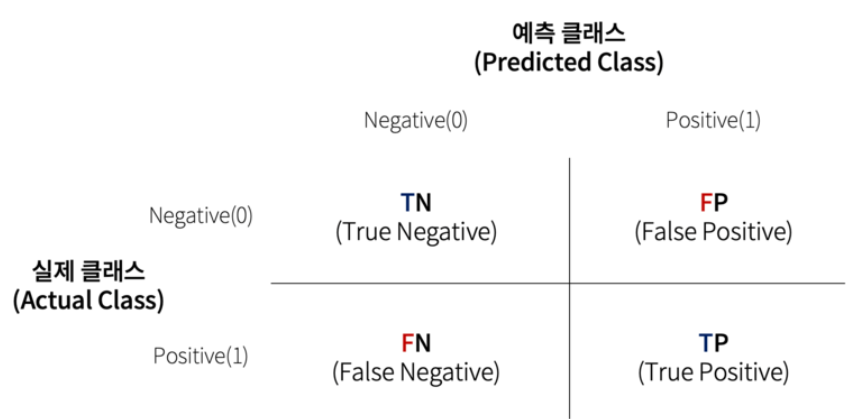

In [6]:
from IPython.display import Image

# 오차행렬
Image('image/오차행렬.png')

In [7]:
# confusion_matrix() : 사이킷런이 제공하는 오차행렬을 구하기 위한 API

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

### 3. 정밀도와 재현율

    Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
    
    1) 정밀도 = TP / (FP + TP)
       - 실제 Negative 음성데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
          ex) 스팸메일 여부 판단 모델.
    2) 재현율(=민감도, TPR) = TP / (FN + TP)
       - 실제 Positive 양성데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 사용
          ex) 암 판단 모델, 금융 사기 적발 모델
    
    둘 모두 TP는 증가 하지만 정밀도는 FP의 감소, 재현율은 FN의 감소를 목표로 함.

In [8]:
## 정확도 : accuracy_score, 정밀도 : precision_score, 재현율 : recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 평가지표를 모두 호출하는 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}')

In [9]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측 및 평가 수행

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df = pd.read_csv('data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=95)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059


C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 4. 정밀도/재현율 트레이드오프
    분류의 결정 임계값을 조정하면 정밀도 or 재현율의 수치를 올릴 수 있음
    but 정밀도와 재현율은 상호보완적인 관계이므로 하나를 강제로 높이면 다른 하나는 떨어짐 -> Trade-off
    
    사이킷런의 분류 결정 방식은 각 데이터가 어떤 레이블에 속할 지 확률은 구한 후 더 높은 확률을 가진 레이블로 예측
    이 때 결정 임곗값을 높이면 임의대로 정밀도 or 재현율을 끌어올릴 수 있음

In [10]:
# pred_proba() : 개별 클래스의 예측 확률을 반환하는 메서드
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print(f'pred_proba() 결과 Shape : {pred_proba.shape}')
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

## 예측확률 array와 예측 결괏값 array를 변합해 예측확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두개의 class중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.8534678  0.1465322 ]
 [0.36202414 0.63797586]
 [0.95290397 0.04709603]]
두개의 class중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.8534678  0.1465322  0.        ]
 [0.36202414 0.63797586 1.        ]
 [0.95290397 0.04709603 0.        ]]


In [11]:
# Binarizer: threshold값보다 같거나 작으면 0, 크면 1을 반환하는 클래스

from sklearn.preprocessing import Binarizer

X = [[1,  -1,   2],
     [2,   0,   0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
## Binarizer의 threshold 설정값 (=분류 결정 임계값)
custom_threshold = 0.5

## predict_proba() 반환값의 두 번쨰 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059


In [13]:
## Binarizer의 threshold 설정값 (=분류 결정 임계값) 조정
## 임계값이 낮아졌으므로 더 많은 데이터를 True로 예측 -> 재현율 상승
custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
get_clf_eval(y_test, custom_predict)

오차행렬
[[89 22]
 [16 52]]
정확도: 0.7877, 정밀도: 0.7027, 재현율: 0.7647


In [14]:
pred_proba

array([[0.8534678 , 0.1465322 ],
       [0.36202414, 0.63797586],
       [0.95290397, 0.04709603],
       [0.86258337, 0.13741663],
       [0.8684858 , 0.1315142 ],
       [0.16119494, 0.83880506],
       [0.04898362, 0.95101638],
       [0.85605706, 0.14394294],
       [0.88623781, 0.11376219],
       [0.29525731, 0.70474269],
       [0.83573352, 0.16426648],
       [0.52352059, 0.47647941],
       [0.83882218, 0.16117782],
       [0.89386025, 0.10613975],
       [0.87752764, 0.12247236],
       [0.51613029, 0.48386971],
       [0.91082989, 0.08917011],
       [0.32216824, 0.67783176],
       [0.08477662, 0.91522338],
       [0.30043346, 0.69956654],
       [0.90382849, 0.09617151],
       [0.40375805, 0.59624195],
       [0.83573352, 0.16426648],
       [0.90625125, 0.09374875],
       [0.87487738, 0.12512262],
       [0.51745354, 0.48254646],
       [0.73553794, 0.26446206],
       [0.05539561, 0.94460439],
       [0.05834239, 0.94165761],
       [0.93201599, 0.06798401],
       [0.

In [15]:
## 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test ,pred_proba_c1, thresholds):
    ## thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('##임곗값 :',custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

##임곗값 : 0.4
오차행렬
[[89 22]
 [16 52]]
정확도: 0.7877, 정밀도: 0.7027, 재현율: 0.7647
##임곗값 : 0.45
오차행렬
[[92 19]
 [16 52]]
정확도: 0.8045, 정밀도: 0.7324, 재현율: 0.7647
##임곗값 : 0.5
오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059
##임곗값 : 0.55
오차행렬
[[99 12]
 [21 47]]
정확도: 0.8156, 정밀도: 0.7966, 재현율: 0.6912
##임곗값 : 0.6
오차행렬
[[103   8]
 [ 25  43]]
정확도: 0.8156, 정밀도: 0.8431, 재현율: 0.6324


#### 4.1 precision_recall_curve() API : 임곗값 변화에 따른 평가 지표 값을 출력

In [16]:
## 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    ## thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('##임계값 :',custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print('\n')
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

##임계값 : 0.4
오차행렬
[[89 22]
 [16 52]]
정확도: 0.7877, 정밀도: 0.7027, 재현율: 0.7647


##임계값 : 0.45
오차행렬
[[92 19]
 [16 52]]
정확도: 0.8045, 정밀도: 0.7324, 재현율: 0.7647


##임계값 : 0.5
오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059


##임계값 : 0.55
오차행렬
[[99 12]
 [21 47]]
정확도: 0.8156, 정밀도: 0.7966, 재현율: 0.6912


##임계값 : 0.6
오차행렬
[[103   8]
 [ 25  43]]
정확도: 0.8156, 정밀도: 0.8431, 재현율: 0.6324




In [17]:
from sklearn.metrics import precision_recall_curve

## 레이블 값이 1일 떄의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

## 실제값 데이터 세트와 레이블 값이 1일 떄의 예측확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

## 반환된 임계값 배열 로우가 150건이므로 샘플로 10건만 추출하되, 임계값을 15Step으로 추출
thr_index = np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index],2))

## 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (150,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1  0.11 0.13 0.14 0.21 0.37 0.53 0.63 0.75 0.92]
샘플 임계값별 정밀도: [0.439 0.471 0.512 0.574 0.62  0.675 0.77  0.911 1.    1.   ]
샘플 임계값별 재현율: [1.    0.956 0.926 0.912 0.838 0.765 0.691 0.603 0.441 0.221]


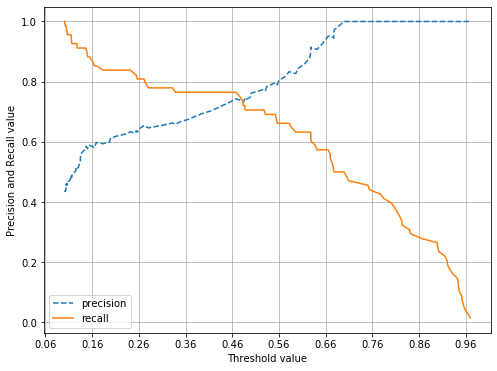

In [18]:
# 정밀도 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    ## threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    ## X축을 threshold값으로, Y축을 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    ## threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    ## x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 5. FI 스코어

    정밀도와 재현율을 결합하여 두 수치가 치우치지 않을수록 높은 값을 반환하는 지표
    F1 = 2 * (정확도 * 재현율) / (정확도 + 재현율)
    
    사이킷런에서는 f1_score() 라는 API를 제공

In [19]:
# 타이타닉 데이터의 f1_score()를 계산
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f'F1 스코어: {f1:.4f}')

F1 스코어: 0.7328


In [20]:
y_test.shape

(179,)

In [21]:
# 평가지표 함수 get_clf_eval() 함수에 F1 스코어를 구하는 로직 추가

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}')
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

##임계값 : 0.4
오차행렬
[[89 22]
 [16 52]]
정확도: 0.7877, 정밀도: 0.7027, 재현율: 0.7647, F1: 0.7324


##임계값 : 0.45
오차행렬
[[92 19]
 [16 52]]
정확도: 0.8045, 정밀도: 0.7324, 재현율: 0.7647, F1: 0.7482


##임계값 : 0.5
오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059, F1: 0.7328


##임계값 : 0.55
오차행렬
[[99 12]
 [21 47]]
정확도: 0.8156, 정밀도: 0.7966, 재현율: 0.6912, F1: 0.7402


##임계값 : 0.6
오차행렬
[[103   8]
 [ 25  43]]
정확도: 0.8156, 정밀도: 0.8431, 재현율: 0.6324, F1: 0.7227




In [22]:
# 평가지표 함수 get_clf_eval() 함수에 F1 스코어를 구하는 로직 추가

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 스코어: {f1:.4f}')

get_clf_eval(y_test, pred)
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059, F1 스코어: 0.7328
##임계값 : 0.4
오차행렬
[[89 22]
 [16 52]]
정확도: 0.7877, 정밀도: 0.7027, 재현율: 0.7647, F1 스코어: 0.7324


##임계값 : 0.45
오차행렬
[[92 19]
 [16 52]]
정확도: 0.8045, 정밀도: 0.7324, 재현율: 0.7647, F1 스코어: 0.7482


##임계값 : 0.5
오차행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059, F1 스코어: 0.7328


##임계값 : 0.55
오차행렬
[[99 12]
 [21 47]]
정확도: 0.8156, 정밀도: 0.7966, 재현율: 0.6912, F1 스코어: 0.7402


##임계값 : 0.6
오차행렬
[[103   8]
 [ 25  43]]
정확도: 0.8156, 정밀도: 0.8431, 재현율: 0.6324, F1 스코어: 0.7227




### 6. ROC 곡선과 AUC
    1) ROC곡선 : X축이 FPR, Y축이 TPR인 곡선
                 ROC곡선이 중앙을 관통하는 일직선과의 거리가 멀어질수록 모델의 성능이 좋음 
        ㄱ) FPR(False Positive Rate) = FP / (FP + TN), 실제 음성데이터 중 양성데이터라고 잘못판단한 정도
        ㄴ) TPR(True Positive Rate) = TP / (FN + TP), 실제 양성데이터 중 양성데이터로 제대로 판단한 정도 (= 재현율)
        
     2) AUC : ROC곡선 밑의 면적

In [23]:
# roc_curve() API : ROC 곡선을 쉽게 구해주는 API
from sklearn.metrics import roc_curve

## 레이블 값이 1일 떄의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

## 반환된 임계값 배열 로우가 46개이므로 샘플로 10건만 추출하되, 임계값을 5 Step으로 추출
## thresholds[0]은 max(예측확률)+1 로 임의설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값 별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임계값 별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41]
샘플용 10개의 임계값:  [0.97 0.63 0.53 0.47 0.28 0.24 0.15 0.12 0.1 ]
샘플 임계값 별 FPR: [0.    0.036 0.126 0.162 0.261 0.297 0.378 0.613 0.712]
샘플 임계값 별 TPR: [0.015 0.632 0.691 0.765 0.779 0.838 0.882 0.926 0.985]


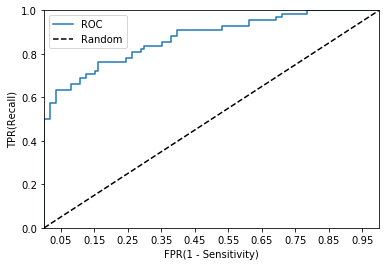

In [24]:
# ROC곡선 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    ## 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    ## ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    ## FPR X 축의 Scale을 0.1 단위로 변경, X, Y 축 명 설정 등
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0, 1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [25]:
# AUC값 구하기
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f'ROC AUC값 : {roc_score:.4f}')

ROC AUC값 : 0.8739


In [26]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[96 15]
 [20 48]]
정확도: 0.8045, 정밀도: 0.7619, 재현율: 0.7059, F1: 0.7328, AUC:0.8739
